In [5]:
#Link to google drive to get access to the dataset
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/IDVE_3')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!pip install minisom

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from minisom import MiniSom


1. Data cleaning:

In [8]:
data = pd.read_csv("/content/gdrive/MyDrive/IDVE_3/nba_2022-23_stats.csv")

In [9]:
data = pd.read_csv("nba_2022-23_stats.csv")

In [10]:
data = data.dropna()

data = data.drop('Unnamed: 0', axis=1)

#remove duplicates depending on player name and team
data = data.drop_duplicates(subset=['Player Name', 'Team'])
# Remove rows with impossible values
data = data[(data['GP'] >= 0) & (data['MP'] >= 0) & (data['Age'] >= 18) & (data['Age'] <= 45)]
data = data[(data['FG%'] >= 0) & (data['FG%'] <= 1) & (data['3P%'] >= 0) & (data['3P%'] <= 1) & (data['FT%'] >= 0) & (data['FT%'] <= 1)]
data = data.reset_index(drop=True)


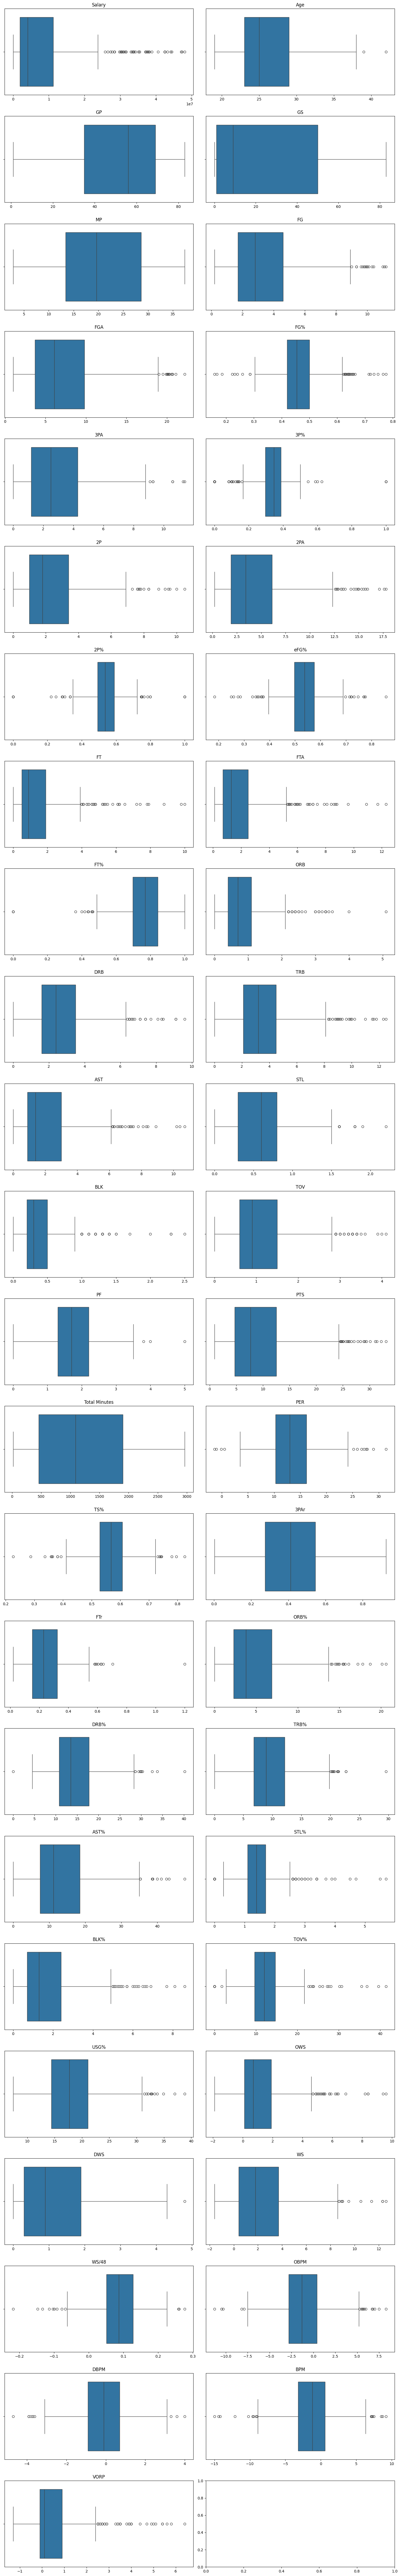

In [11]:
#check for outliers
import matplotlib.pyplot as plt
import seaborn as sns

numerical_columns = data.select_dtypes(include=[np.number]).columns


fig, axes = plt.subplots(nrows=(len(numerical_columns) + 1) // 2, ncols=2, figsize=(15, 4 * ((len(numerical_columns) + 1) // 2)))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [12]:
#removing outliers

def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# List of all columns to check for outliers
all_columns_to_check = ['Age', 'Salary', 'GP', 'MP', 'FG', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

# Columns to consider for removal (excluding Age and Salary)
columns_for_removal = ['GP', 'MP', 'FG', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

# Dictionary to store outliers for each column
outliers_dict = {}

# Identify outliers for each column
for column in all_columns_to_check:
    if column in data.columns:
        outliers = identify_outliers(data, column)
        outliers_dict[column] = outliers
        print(f"Number of outliers in {column}: {outliers.shape[0]}")

# Identify Age and Salary outliers
age_outliers = outliers_dict['Age']
salary_outliers = outliers_dict['Salary']

# Combine Age and Salary outliers
protected_outliers = pd.concat([age_outliers, salary_outliers]).drop_duplicates()

# Remove outliers, but keep Age and Salary outliers, and positive performance outliers
data_cleaned = data.copy()
for column in columns_for_removal:
    if column in ['OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']:
        # Keep positive outliers for these metrics and all Age/Salary outliers
        lower_bound = data_cleaned[column].quantile(0.25) - 1.5 * (data_cleaned[column].quantile(0.75) - data_cleaned[column].quantile(0.25))
        data_cleaned = data_cleaned[(data_cleaned[column] >= lower_bound) | (data_cleaned.index.isin(protected_outliers.index))]
    else:
        # Remove outliers but keep Age and Salary outliers
        data_cleaned = data_cleaned[~data_cleaned.index.isin(outliers_dict[column].index) | (data_cleaned.index.isin(protected_outliers.index))]

print(f"\nOriginal dataset shape: {data.shape}")
print(f"Cleaned dataset shape: {data_cleaned.shape}")

# Verify that Age and Salary outliers are retained
age_outliers_after = identify_outliers(data_cleaned, 'Age')
salary_outliers_after = identify_outliers(data_cleaned, 'Salary')

print(f"\nAge outliers in cleaned data: {age_outliers_after.shape[0]}")
print(f"Salary outliers in cleaned data: {salary_outliers_after.shape[0]}")

# Display summary statistics of the cleaned dataset
print("\nSummary statistics of the cleaned dataset:")
print(data_cleaned.describe())

# Optional: Display Age and Salary outliers for verification
print("\nAge outliers in cleaned data:")
print(age_outliers_after[['Player Name', 'Age', 'Team']])
print("\nSalary outliers in cleaned data:")
print(salary_outliers_after[['Player Name', 'Salary', 'Team']])

# Verification of data retention
print("\nVerification of data retention:")
print(f"Age outliers retained: {all(age_outliers.index.isin(data_cleaned.index))}")
print(f"Salary outliers retained: {all(salary_outliers.index.isin(data_cleaned.index))}")

# Optional: Save the cleaned dataset
# data_cleaned.to_csv('nba_2024_advanced_cleaned.csv', index=False)

Number of outliers in Age: 2
Number of outliers in Salary: 48
Number of outliers in GP: 0
Number of outliers in MP: 0
Number of outliers in FG: 17
Number of outliers in TOV%: 21
Number of outliers in USG%: 11
Number of outliers in OWS: 27
Number of outliers in DWS: 1
Number of outliers in WS: 11
Number of outliers in WS/48: 12
Number of outliers in OBPM: 16
Number of outliers in DBPM: 10
Number of outliers in BPM: 17
Number of outliers in VORP: 36

Original dataset shape: (433, 51)
Cleaned dataset shape: (405, 51)

Age outliers in cleaned data: 2
Salary outliers in cleaned data: 45

Summary statistics of the cleaned dataset:
             Salary         Age          GP          GS          MP  \
count  4.050000e+02  405.000000  405.000000  405.000000  405.000000   
mean   9.388866e+06   26.041975   53.185185   25.323457   21.310123   
std    1.110097e+07    4.367490   21.545664   27.603389    8.811532   
min    3.279500e+04   19.000000    1.000000    0.000000    2.800000   
25%    2.000

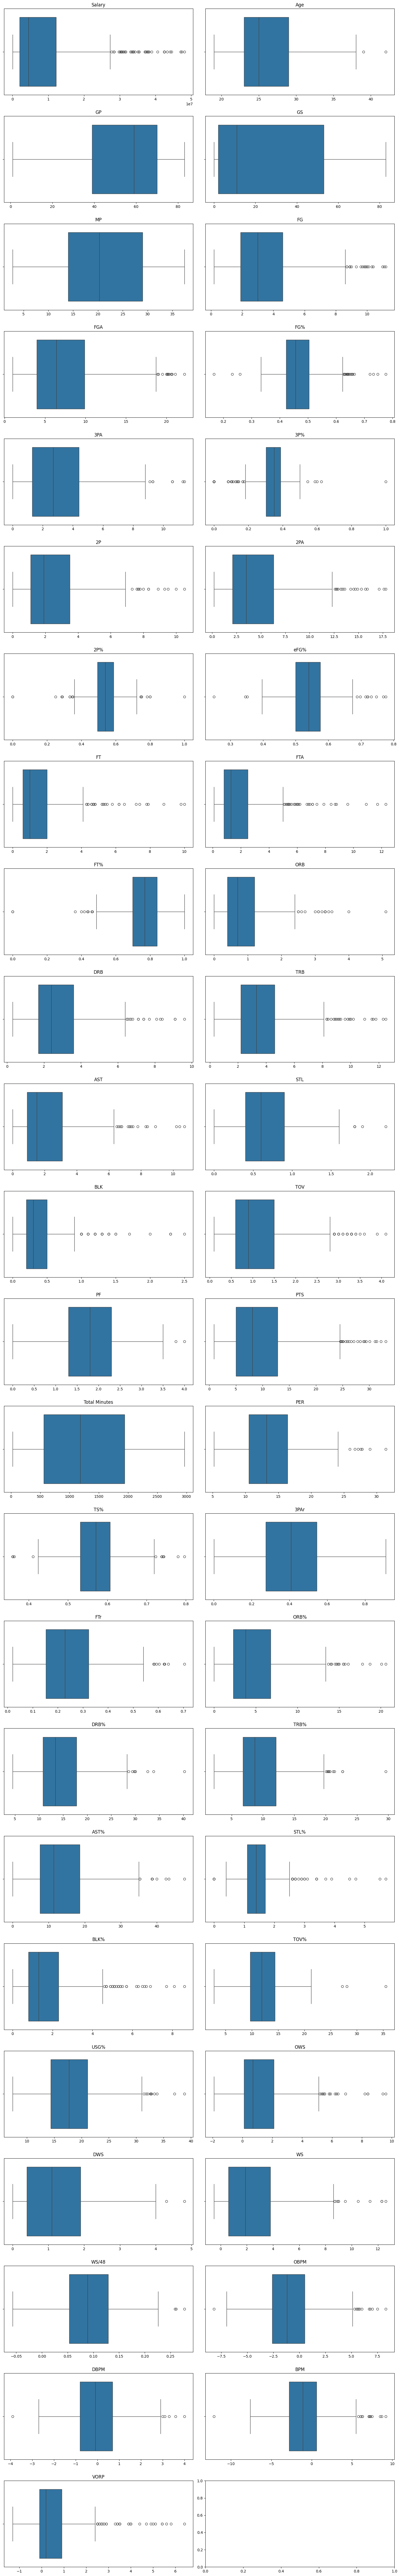

In [13]:
#check for outliers
import matplotlib.pyplot as plt
import seaborn as sns

data = data_cleaned

numerical_columns = data.select_dtypes(include=[np.number]).columns


fig, axes = plt.subplots(nrows=(len(numerical_columns) + 1) // 2, ncols=2, figsize=(15, 4 * ((len(numerical_columns) + 1) // 2)))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()



Outlier Analysis:
We identified outliers in several categories, with the most significant numbers in:
-Salary (48 outliers)
-VORP (36 outliers)
-OWS (27 outliers)
-TOV% (21 outliers)

Dataset Reduction:
Original dataset: 433 rows
After initial outlier removal: 337 rows
After efficiency (WS/48) outlier removal: 333 rows

Odd Points:
a) Age: We identified 2 outliers. Given the range (19-37), these likely represent very young rookies or veteran players.
b) Salary: The high number of outliers (48) suggests a wide disparity in player salaries, which is common in the NBA.
c) VORP and OWS: The high number of outliers in these advanced metrics might indicate players with exceptional positive or negative impacts.

Decision on Outlier Removal:
a) Age outliers: We recommend keeping these. Age extremes are valid in basketball and can provide valuable insights.
b) Salary outliers: We suggest keeping these as well. Salary disparities are a reality in the NBA and often correlate with performance or player status.
c) Performance metric outliers (VORP, OWS, BPM, etc.):
We advise keeping positive outliers as they likely represent star players.
We consider removing extreme negative outliers, as they might represent players with very limited playing time.
d) Efficiency outlier (WS/48): The removal of 4 additional outliers seems reasonable to us, as extreme efficiency values might skew analysis.

Justification:

We recognize that basketball often has legitimate statistical outliers due to varying roles, playing time, and skill levels.
We caution that removing too many outliers might eliminate important data points representing star players or unique roles.
We note that the current approach reduced the dataset by about 23%, which is significant.



2.

1a)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.2301 - val_loss: 1.6231
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1000 - val_loss: 1.4861
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0181 - val_loss: 1.2590
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9304 - val_loss: 1.0781
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7882 - val_loss: 1.0274
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7399 - val_loss: 1.0201
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7540 - val_loss: 1.0194
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7229 - val_loss: 1.0160
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6791 - val_loss: 1.0097
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7085 - val_loss: 1.0026
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6784 - val_loss: 0.9909
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

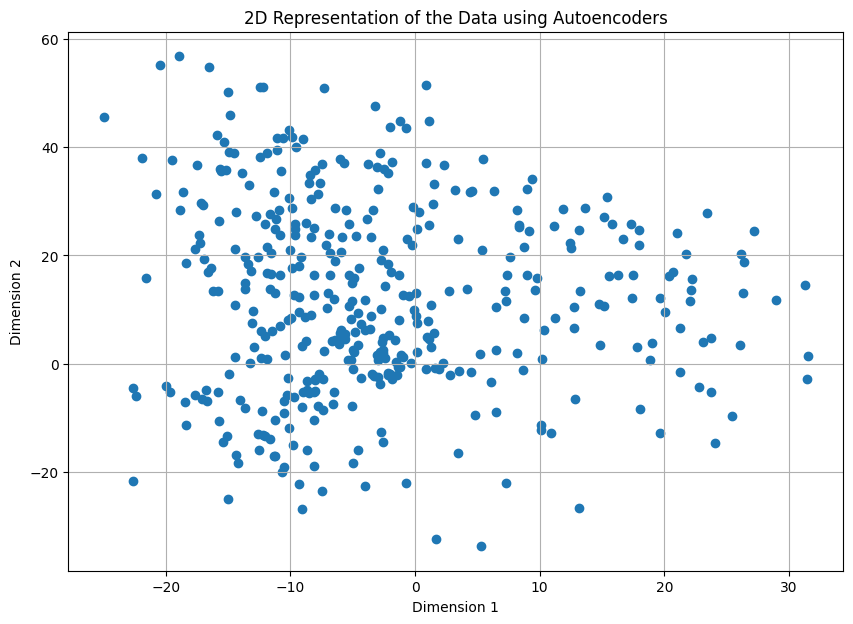

In [14]:
# Select only numerical columns
numerical_data = data_cleaned.select_dtypes(include=[np.number])

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numerical_data)

# Autoencoder
input_dim = data_scaled.shape[1]  # Number of features
encoding_dim = 2  # Reduced dimension

# Model
input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(32, activation='relu')(encoder)
encoder_output = layers.Dense(encoding_dim, activation='linear')(encoder)

decoder = layers.Dense(32, activation='relu')(encoder_output)
decoder = layers.Dense(64, activation='relu')(decoder)
decoder_output = layers.Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder_output)
encoder_model = keras.Model(inputs=input_layer, outputs=encoder_output)

# Compile
autoencoder.compile(optimizer='adam', loss='mse')

# Train
autoencoder.fit(data_scaled, data_scaled, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

# Encode
encoded_data = encoder_model.predict(data_scaled)

# Convert to DataFrame for plotting
encoded_df = pd.DataFrame(encoded_data, columns=['Dimension 1', 'Dimension 2'])

# Visualize encoded data
plt.figure(figsize=(10, 7))
plt.scatter(encoded_df['Dimension 1'], encoded_df['Dimension 2'])
plt.title('2D Representation of the Data using Autoencoders')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.show()


The scatter plot reveals the distribution of data points in two dimensions, allowing us to observe potential clusters or patterns that may exist within the dataset.
The presence of distinct clusters suggests that certain groups share similar characteristics.
The spread of points across the plot indicates the variance in the dataset, with tightly packed points representing similar observations.

The scatter plot shows several distinct clusters of points, each concentrated in separate areas. This indicates that there are groups of similar observations in the dataset.
There are points which are densely packed in certain areas, potentially overlapping. This suggests that there are many observations with similar characteristics.
The points form a linear or near-linear pattern. This indicates a strong correlation between two features represented in the dimensions.

b)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1576 - val_loss: 1.5885
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1100 - val_loss: 1.4664
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0676 - val_loss: 1.2886
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9381 - val_loss: 1.1287
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8941 - val_loss: 1.0329
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7926 - val_loss: 1.0142
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7520 - val_loss: 1.0119
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7719 - val_loss: 1.0107
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7246 - val_loss: 1.0092
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7399 - val_loss: 1.0041
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7323 - val_loss: 1.0025
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

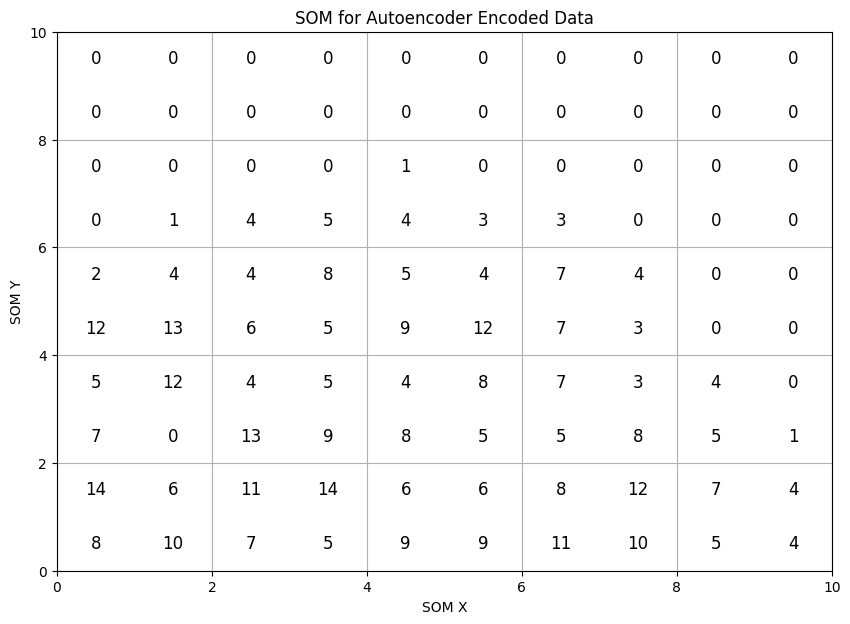

In [35]:
# Autoencoder
encoding_dim = 10  # Intermediate dimension before reducing to 2D

# Model
input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(32, activation='relu')(encoder)
encoder_output = layers.Dense(encoding_dim, activation='relu')(encoder)

decoder = layers.Dense(32, activation='relu')(encoder_output)
decoder = layers.Dense(64, activation='relu')(decoder)
decoder_output = layers.Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder_output)
encoder_model = keras.Model(inputs=input_layer, outputs=encoder_output)

# Compile
autoencoder.compile(optimizer='adam', loss='mse')

# Train
autoencoder.fit(data_scaled, data_scaled, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

# Encode
encoded_data = encoder_model.predict(data_scaled)

# Initialize SOM
som_size = 10  # Size of the SOM grid
som = MiniSom(som_size, som_size, encoding_dim, sigma=1.0, learning_rate=0.5)

# Train SOM
som.train(encoded_data, num_iteration=1000)

# Get winning nodes
win_map = som.win_map(encoded_data)

# # Visualize the SOM
plt.figure(figsize=(10, 7))
plt.title('SOM for Autoencoder Encoded Data')
for x in range(som_size):
    for y in range(som_size):
        plt.text(x + 0.5, y + 0.5, str(len(win_map[(x, y)])), ha='center', va='center', fontsize=12)

plt.xlim(0, som_size)
plt.ylim(0, som_size)
plt.xlabel('SOM X')
plt.ylabel('SOM Y')
plt.grid()
plt.show()

# plt.figure(figsize=(12, 10))
# plt.title('SOM for Autoencoder Encoded Data', fontsize=14, pad=20)

# # Create count matrix
# counts = np.zeros((som_size, som_size))
# for x in range(som_size):
#     for y in range(som_size):
#         counts[y, x] = len(win_map.get((x, y), []))

# # Create heatmap
# heatmap = plt.imshow(counts, cmap='viridis')  # or try: 'YlOrRd', 'Blues', 'RdYlBu_r'
# plt.colorbar(heatmap, label='Number of samples in node')

# # Add text annotations
# for x in range(som_size):
#     for y in range(som_size):
#         plt.text(x, y, str(int(counts[y, x])),
#                 ha='center',
#                 va='center',
#                 color='white' if counts[y, x] > np.max(counts)/2 else 'black',
#                 fontweight='bold',
#                 fontsize=10)

# plt.grid(True, color='white', linestyle='-', linewidth=0.5, alpha=0.3)
# plt.xlabel('SOM X', fontsize=12)
# plt.ylabel('SOM Y', fontsize=12)

# # Add tick marks
# plt.xticks(range(som_size))
# plt.yticks(range(som_size))

# plt.tight_layout()
# plt.show()


The grid shows an integration a Self-Organizing Map (SOM) following the autoencoder, allowing us to visualize the encoded data more effectively. The grid is visualized by counting the number of encoded data points associated with each node, providing insight into the density and distribution of the encoded representations.

The grid shows several nodes with high counts, indicating clusters of similar encoded data points.This suggests that certain groups in the dataset share similar characteristics.
The zeros in the top right corner suggest that there are combinations of features that are either rare or non-existent. The rest of the grid having high counts while the top right is empty implies that the data points cluster around specific characteristics/combinations that are more common. This pattern suggests that there are certain features that, when combined, do not appear together frequently.

c)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.1658 - val_loss: 1.6394
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1594 - val_loss: 1.5693
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0752 - val_loss: 1.4061
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9224 - val_loss: 1.1696
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7669 - val_loss: 1.0398
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7452 - val_loss: 1.0173
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7193 - val_loss: 1.0129
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6669 - val_loss: 1.0090
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6332 - val_loss: 1.0020
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6678 - val_loss: 0.9950
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6442 - val_loss: 0.9907
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0

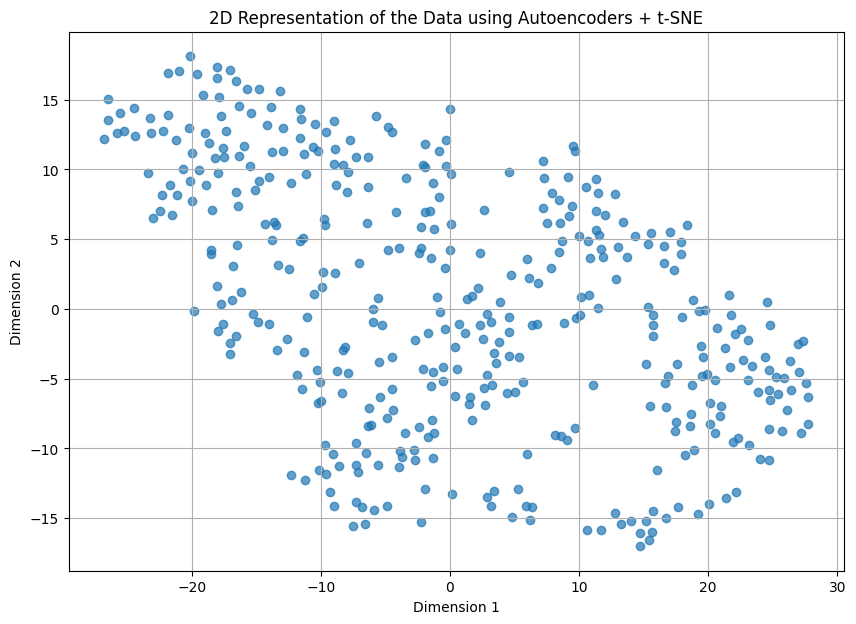

In [16]:
# Autoencoder
encoding_dim = 10  # Intermediate dimension

# Model
input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(32, activation='relu')(encoder)
encoder_output = layers.Dense(encoding_dim, activation='relu')(encoder)

decoder = layers.Dense(32, activation='relu')(encoder_output)
decoder = layers.Dense(64, activation='relu')(decoder)
decoder_output = layers.Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder_output)
encoder_model = keras.Model(inputs=input_layer, outputs=encoder_output)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(data_scaled, data_scaled, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

# Encode the data
encoded_data = encoder_model.predict(data_scaled)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(encoded_data)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])

# Visualize the t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], alpha=0.7)
plt.title('2D Representation of the Data using Autoencoders + t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.show()


The scatter plot view is a combination of an autoencoder with t-SNE to visualize high-dimensional data in a two-dimensional space. The resulting scatter plot from the t-SNE application illustrates how the encoded data points relate to each other in a 2D space.

The points are evenly distributed across the plot with several weak clusters but no distinct strong clusters. This suggests that the data does not contain well-defined groups and that the observations may vary in characteristics.

In [17]:
pip install umap-learn

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 1.1289 - val_loss: 1.5832
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0881 - val_loss: 1.4205
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9945 - val_loss: 1.1987
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9256 - val_loss: 1.0622
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8193 - val_loss: 1.0212
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7775 - val_loss: 1.0163
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7174 - val_loss: 1.0132
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7006 - val_loss: 0.9985
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6575 - val_loss: 0.9795
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6466 - val_loss: 0.9672
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6512 - val_loss: 0.9656
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


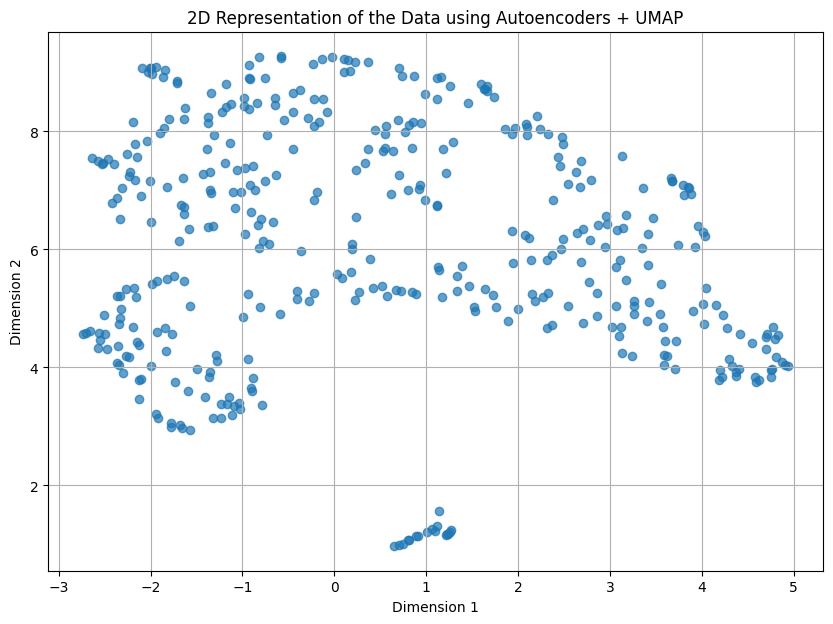

In [18]:
import umap
# Define the Autoencoder
input_dim = data_scaled.shape[1]
encoding_dim = 10  # Intermediate dimension

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(32, activation='relu')(encoder)
encoder_output = layers.Dense(encoding_dim, activation='relu')(encoder)

decoder = layers.Dense(32, activation='relu')(encoder_output)
decoder = layers.Dense(64, activation='relu')(decoder)
decoder_output = layers.Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder_output)
encoder_model = keras.Model(inputs=input_layer, outputs=encoder_output)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(data_scaled, data_scaled, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

# Encode the data
encoded_data = encoder_model.predict(data_scaled)

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(encoded_data)

# Create a DataFrame for visualization
umap_df = pd.DataFrame(umap_results, columns=['Dimension 1', 'Dimension 2'])

# Visualize the UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(umap_df['Dimension 1'], umap_df['Dimension 2'], alpha=0.7)
plt.title('2D Representation of the Data using Autoencoders + UMAP')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.show()

The combination of autoencoders and UMAP for dimensionality reduction on the NBA dataset has led to better separation among clusters from the originally sparse high-dimensional data. Although the clustering is not perfectly distinct, it shows an improvement compared to the results obtained using Autoencoders + t-SNE. UMAP, combined with autoencoders, effectively reduces the high-dimensional data to a two-dimensional representation, preserving more of the global structure. This results in better-separated clusters compared to t-SNE, which sometimes can conflate clusters due to its focus on preserving local structure. The visualization indicates that the data points are more evenly distributed and the clusters are more discernible.

While the clusters are not perfectly distinct, the separation is more apparent than with t-SNE. This suggests that UMAP, with its ability to maintain both local and global structures of the data, provides a more meaningful representation in the reduced dimensions. The clusters show some degree of overlap, which might indicate intrinsic similarities within the data points or limitations in the chosen dimensionality reduction and clustering approach.

e)

In [28]:
from sklearn import preprocessing

data['3P'] = pd.to_numeric(data['3P'], errors='coerce')  # This will convert non-numeric values to NaN
# Handle NaN values in '3P'
if data['3P'].isnull().any():
    print("NaN values found in '3P' column. Filling NaNs with 0.")
    data['3P'].fillna(0, inplace=True)

# Step 1: Initialize the LabelEncoder
label_encoder = preprocessing.LabelEncoder()

# Step 2: Encode 'Player Name', 'Position', and 'Team'
data['Player Name Encoded'] = label_encoder.fit_transform(data['Player Name'])
data['Position Encoded'] = label_encoder.fit_transform(data['Position'])
data['Team Encoded'] = label_encoder.fit_transform(data['Team'])

# Step 3: Drop original categorical columns (optional)
data = data.drop(columns=['Player Name', 'Position', 'Team'])



In [1]:
pip install pythae


Preprocessing train data...
INFO:pythae.pipelines.training:Preprocessing train data...
Checking train dataset...
INFO:pythae.pipelines.training:Checking train dataset...
Preprocessing eval data...

INFO:pythae.pipelines.training:Preprocessing eval data...

Checking eval dataset...
INFO:pythae.pipelines.training:Checking eval dataset...
Using Base Trainer

INFO:pythae.pipelines.training:Using Base Trainer

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Model passed sanity check !
Ready for training.

INFO:pythae.trainers.base_trainer.base_trainer:Model passed sanity check !
Ready for tr

Training of epoch 1/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 1/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 28.779
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 28.779
Eval loss: 34.7018
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 34.7018
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 2/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 2/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 24.6468
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 24.6468
Eval loss: 31.765
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 31.765
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 3/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 3/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 22.5497
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 22.5497
Eval loss: 28.9846
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.9846
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 4/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 4/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 23.4262
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 23.4262
Eval loss: 30.1794
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 30.1794
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 5/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 5/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 22.1431
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 22.1431
Eval loss: 28.8014
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.8014
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 6/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 6/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 22.3694
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 22.3694
Eval loss: 28.0992
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.0992
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 7/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 7/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 22.1835
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 22.1835
Eval loss: 29.2609
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 29.2609
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 8/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 8/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 22.2568
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 22.2568
Eval loss: 28.1604
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.1604
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 9/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 9/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 21.3795
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 21.3795
Eval loss: 29.9928
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 29.9928
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 10/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 10/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.8249
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.8249
Eval loss: 27.8046
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.8046
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 11/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 11/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.7555
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.7555
Eval loss: 29.7557
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 29.7557
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 12/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 12/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.1114
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.1114
Eval loss: 28.0621
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.0621
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 13/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 13/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.6304
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.6304
Eval loss: 27.669
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.669
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 14/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 14/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.3224
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.3224
Eval loss: 27.9467
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.9467
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 15/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 15/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.9213
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.9213
Eval loss: 27.782
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.782
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 16/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 16/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5704
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5704
Eval loss: 25.4563
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.4563
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 17/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 17/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.7975
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.7975
Eval loss: 25.277
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.277
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 18/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 18/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3484
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3484
Eval loss: 26.5278
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.5278
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 19/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 19/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.5618
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.5618
Eval loss: 26.9403
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.9403
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 20/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 20/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.4115
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.4115
Eval loss: 29.5125
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 29.5125
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 21/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 21/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3897
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3897
Eval loss: 27.1868
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.1868
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 22/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 22/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.7539
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.7539
Eval loss: 28.2588
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.2588
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 23/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 23/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.3064
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.3064
Eval loss: 27.1507
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.1507
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 24/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 24/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.315
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.315
Eval loss: 28.2597
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.2597
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 25/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 25/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.4905
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.4905
Eval loss: 28.3882
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.3882
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 26/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 26/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.1329
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.1329
Eval loss: 28.8599
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.8599
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 27/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 27/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.2717
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.2717
Eval loss: 27.7858
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.7858
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 28/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 28/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.2426
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.2426
Eval loss: 25.6556
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.6556
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 29/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 29/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.3154
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.3154
Eval loss: 25.3492
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.3492
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 30/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 30/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.8918
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.8918
Eval loss: 25.1307
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.1307
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 31/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 31/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.3183
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.3183
Eval loss: 27.1383
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.1383
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 32/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 32/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.8613
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.8613
Eval loss: 25.4456
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.4456
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 33/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 33/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.8734
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.8734
Eval loss: 25.9541
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.9541
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 34/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 34/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.8437
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.8437
Eval loss: 26.5939
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.5939
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 35/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 35/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.0826
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.0826
Eval loss: 27.8041
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.8041
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 36/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 36/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3312
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3312
Eval loss: 26.7059
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.7059
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 37/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 37/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.2061
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.2061
Eval loss: 26.5231
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.5231
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 38/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 38/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.2009
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.2009
Eval loss: 29.6078
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 29.6078
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 39/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 39/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.8177
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.8177
Eval loss: 27.9688
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.9688
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 40/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 40/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3861
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3861
Eval loss: 27.3887
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.3887
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 41/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 41/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5367
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5367
Eval loss: 25.0859
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.0859
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 42/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 42/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.119
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.119
Eval loss: 25.9703
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.9703
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 43/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 43/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.8699
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.8699
Eval loss: 24.5253
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.5253
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 44/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 44/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.4473
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.4473
Eval loss: 25.7245
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.7245
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 45/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 45/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.3109
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.3109
Eval loss: 27.2617
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.2617
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 46/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 46/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.8701
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.8701
Eval loss: 26.1189
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.1189
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 47/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 47/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5676
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5676
Eval loss: 25.6179
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.6179
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 48/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 48/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.6318
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.6318
Eval loss: 27.8426
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.8426
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 49/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 49/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.326
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.326
Eval loss: 26.2515
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.2515
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 50/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 50/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.1021
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.1021
Eval loss: 27.0238
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.0238
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 51/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 51/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.463
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.463
Eval loss: 26.9453
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.9453
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 52/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 52/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.4696
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.4696
Eval loss: 25.8466
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.8466
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 53/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 53/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.4237
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.4237
Eval loss: 26.5153
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.5153
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 54/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 54/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.6198
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.6198
Eval loss: 24.2346
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.2346
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 55/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 55/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.1815
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.1815
Eval loss: 25.9077
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.9077
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 56/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 56/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.7866
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.7866
Eval loss: 26.5218
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.5218
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 57/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 57/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.6866
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.6866
Eval loss: 26.1378
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.1378
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 58/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 58/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.7251
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.7251
Eval loss: 26.0219
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.0219
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 59/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 59/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.627
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.627
Eval loss: 25.3428
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.3428
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 60/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 60/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.1324
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.1324
Eval loss: 27.2803
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.2803
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 61/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 61/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.0314
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.0314
Eval loss: 25.3515
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.3515
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 62/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 62/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3003
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3003
Eval loss: 26.6735
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.6735
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 63/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 63/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.1633
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.1633
Eval loss: 25.3329
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.3329
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 64/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 64/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.7747
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.7747
Eval loss: 27.7584
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.7584
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 65/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 65/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.9553
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.9553
Eval loss: 27.0707
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.0707
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 66/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 66/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5719
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5719
Eval loss: 26.4352
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.4352
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 67/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 67/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.318
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.318
Eval loss: 25.7866
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.7866
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 68/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 68/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.8317
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.8317
Eval loss: 26.2783
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.2783
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 69/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 69/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.8998
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.8998
Eval loss: 26.5468
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.5468
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 70/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 70/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.8037
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.8037
Eval loss: 27.4949
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.4949
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 71/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 71/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5151
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5151
Eval loss: 26.5002
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.5002
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 72/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 72/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.7099
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.7099
Eval loss: 26.3716
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.3716
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 73/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 73/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.2383
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.2383
Eval loss: 26.8984
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.8984
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 74/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 74/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.0909
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.0909
Eval loss: 26.0393
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.0393
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 75/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 75/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.6732
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.6732
Eval loss: 27.0959
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.0959
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 76/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 76/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.2475
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.2475
Eval loss: 23.9496
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 23.9496
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 77/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 77/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.2759
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.2759
Eval loss: 24.4741
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.4741
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 78/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 78/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.9337
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.9337
Eval loss: 27.0716
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.0716
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 79/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 79/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.134
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.134
Eval loss: 25.7926
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.7926
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 80/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 80/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.388
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.388
Eval loss: 28.6673
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.6673
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 81/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 81/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.0132
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.0132
Eval loss: 24.5057
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.5057
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 82/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 82/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.4896
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.4896
Eval loss: 24.952
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.952
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 83/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 83/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.1559
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.1559
Eval loss: 26.1047
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.1047
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 84/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 84/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.7196
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.7196
Eval loss: 27.041
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.041
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 85/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 85/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.0128
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.0128
Eval loss: 27.285
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.285
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 86/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 86/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.8169
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.8169
Eval loss: 24.0789
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.0789
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 87/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 87/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3267
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3267
Eval loss: 26.3754
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.3754
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 88/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 88/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.7524
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.7524
Eval loss: 28.5014
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.5014
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 89/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 89/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.2488
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.2488
Eval loss: 24.8479
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.8479
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 90/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 90/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.1986
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.1986
Eval loss: 25.4173
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.4173
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 91/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 91/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5209
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5209
Eval loss: 26.4882
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.4882
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 92/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 92/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.7787
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.7787
Eval loss: 26.4293
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.4293
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 93/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 93/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.0119
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.0119
Eval loss: 26.9412
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.9412
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 94/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 94/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.4435
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.4435
Eval loss: 26.6337
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.6337
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 95/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 95/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.0183
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.0183
Eval loss: 25.9517
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.9517
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 96/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 96/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5929
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5929
Eval loss: 27.8959
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.8959
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 97/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 97/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.1408
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.1408
Eval loss: 26.7706
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.7706
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 98/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 98/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.9497
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.9497
Eval loss: 25.5071
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.5071
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 99/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 99/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3269
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3269
Eval loss: 27.473
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.473
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 100/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 100/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.9528
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.9528
Eval loss: 26.6149
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.6149
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 101/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 101/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3324
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3324
Eval loss: 29.6525
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 29.6525
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 102/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 102/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.8203
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.8203
Eval loss: 24.4136
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.4136
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 103/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 103/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3949
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3949
Eval loss: 25.5891
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.5891
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 104/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 104/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.2746
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.2746
Eval loss: 24.894
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.894
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 105/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 105/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.1313
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.1313
Eval loss: 26.3099
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.3099
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 106/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 106/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 21.0817
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 21.0817
Eval loss: 28.224
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.224
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 107/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 107/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.8101
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.8101
Eval loss: 27.0496
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.0496
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 108/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 108/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.9191
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.9191
Eval loss: 26.8479
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.8479
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 109/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 109/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.763
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.763
Eval loss: 27.2114
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.2114
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 110/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 110/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.2395
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.2395
Eval loss: 29.2676
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 29.2676
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 111/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 111/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5557
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5557
Eval loss: 26.4169
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.4169
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 112/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 112/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.427
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.427
Eval loss: 27.165
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.165
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 113/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 113/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.955
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.955
Eval loss: 28.4696
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.4696
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 114/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 114/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.7849
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.7849
Eval loss: 26.6956
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.6956
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 115/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 115/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.4306
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.4306
Eval loss: 24.4227
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.4227
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 116/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 116/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.4509
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.4509
Eval loss: 26.6107
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.6107
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 117/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 117/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.2209
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.2209
Eval loss: 28.7544
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.7544
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 118/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 118/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 21.1439
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 21.1439
Eval loss: 27.1303
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.1303
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 119/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 119/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.6939
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.6939
Eval loss: 25.8998
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.8998
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 120/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 120/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.4198
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.4198
Eval loss: 25.9853
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.9853
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 121/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 121/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.2717
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.2717
Eval loss: 27.5468
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.5468
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 122/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 122/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3777
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3777
Eval loss: 26.9299
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.9299
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 123/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 123/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.0687
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.0687
Eval loss: 27.7564
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.7564
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 124/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 124/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.8289
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.8289
Eval loss: 28.1568
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.1568
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 125/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 125/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.1355
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.1355
Eval loss: 25.236
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.236
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 126/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 126/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.3929
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.3929
Eval loss: 27.8681
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.8681
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 127/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 127/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.9644
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.9644
Eval loss: 26.1974
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.1974
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 128/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 128/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.8635
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.8635
Eval loss: 25.8046
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.8046
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 129/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 129/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.9491
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.9491
Eval loss: 25.6193
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.6193
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 130/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 130/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 20.398
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 20.398
Eval loss: 25.5153
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.5153
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 131/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 131/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.1444
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.1444
Eval loss: 26.8287
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.8287
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 132/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 132/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.8976
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.8976
Eval loss: 26.7658
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.7658
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 133/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 133/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.1068
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.1068
Eval loss: 27.1783
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.1783
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 134/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 134/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.8903
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.8903
Eval loss: 23.9972
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 23.9972
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 135/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 135/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5324
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5324
Eval loss: 26.8234
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.8234
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 136/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 136/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.4061
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.4061
Eval loss: 28.1989
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.1989
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 137/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 137/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 21.2463
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 21.2463
Eval loss: 24.4217
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 24.4217
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 138/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 138/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.9915
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.9915
Eval loss: 28.9924
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.9924
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 139/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 139/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.594
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.594
Eval loss: 26.0406
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.0406
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 140/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 140/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.6979
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.6979
Eval loss: 26.4318
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.4318
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 141/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 141/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 22.0538
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 22.0538
Eval loss: 25.2039
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 25.2039
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 142/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 142/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.6071
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.6071
Eval loss: 26.3004
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.3004
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 143/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 143/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 17.7535
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 17.7535
Eval loss: 26.8066
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.8066
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 144/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 144/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5165
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5165
Eval loss: 23.784
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 23.784
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 145/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 145/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.5261
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.5261
Eval loss: 26.3414
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.3414
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 146/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 146/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 19.5236
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 19.5236
Eval loss: 27.5535
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.5535
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 147/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 147/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.7097
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.7097
Eval loss: 26.1776
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 26.1776
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 148/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 148/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.2188
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.2188
Eval loss: 27.9949
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.9949
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 149/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 149/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.2583
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.2583
Eval loss: 27.7638
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 27.7638
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 150/150:   0%|          | 0/6 [00:00<?, ?batch/s]

Eval of epoch 150/150:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 18.0789
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 18.0789
Eval loss: 28.1559
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 28.1559
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Training ended!
INFO:pythae.trainers.base_trainer.base_trainer:Training ended!
Saved final model in dummy_output_dir/VAE_training_2024-10-28_07-55-40/final_model
INFO:pythae.trainers.base_trainer.base_trainer:Saved final model in dummy_output_dir/VAE_training_2024-10-28_07-55-40/final_model


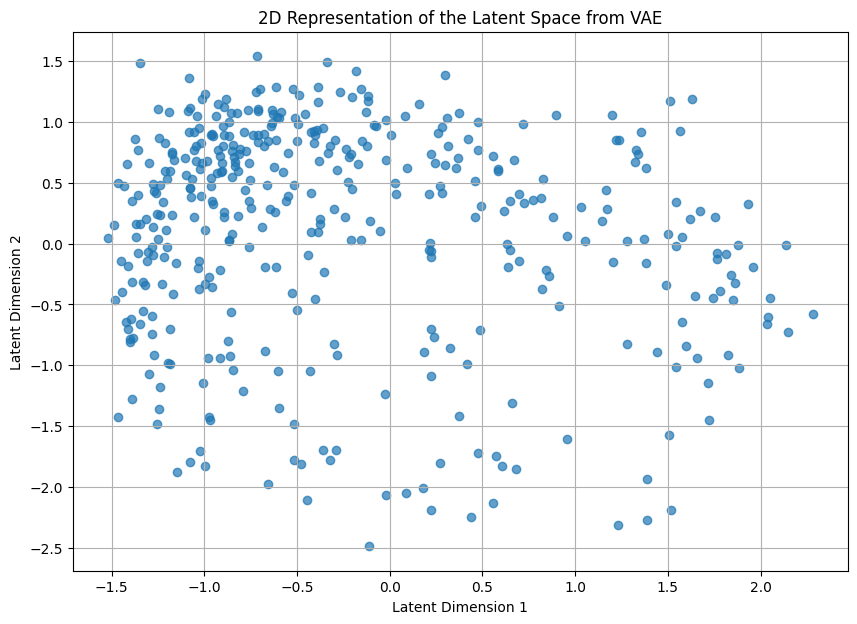

In [29]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pythae.pipelines import TrainingPipeline
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig
from sklearn.preprocessing import StandardScaler

# Standardize the data
data_tensor = torch.tensor(StandardScaler().fit_transform(data), dtype=torch.float32)

# Set up training configuration with potential improvements
my_training_config = BaseTrainerConfig(
    num_epochs=150,  # Increased epochs for potentially better convergence
    learning_rate=1e-3,  # Lowered learning rate for stability
    per_device_train_batch_size=64,  # Adjust batch size based on experimentation
    per_device_eval_batch_size=64,
    train_dataloader_num_workers=4,
    eval_dataloader_num_workers=4,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.1, "betas": (0.9, 0.999)},  # Increased weight decay for regularization
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 10, "factor": 0.5}
)

# Set up model configuration
my_vae_config = VAEConfig(
    input_dim=(data.shape[1],),
    latent_dim=2  # Keep it 2 for visualization purposes, but consider higher dimensions for complex data
)

# Build the model and pipeline
pipeline = TrainingPipeline(
    training_config=my_training_config,
    model=VAE(model_config=my_vae_config)
)

# Split the dataset
train_size = int(0.8 * len(data_tensor))
dl_train_sample = data_tensor[:train_size].numpy()
dl_eval_sample = data_tensor[train_size:].numpy()

# Launch the pipeline
pipeline(train_data=dl_train_sample, eval_data=dl_eval_sample)

# Get latent representations
with torch.no_grad():
    latent_representations = pipeline.model.encoder(data_tensor).embedding.numpy()

# Plot latent space
if isinstance(latent_representations, np.ndarray):
    plt.figure(figsize=(10, 7))
    plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.7)
    plt.title('2D Representation of the Latent Space from VAE')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid()
    plt.show()
else:
    print("Latent representations could not be defined.")


Plot the reduced dataset in two dimensions, for each reduced dataset apply
k-Means to cluster the reduced dataset. Visualise, compare and explore
your results. Which of the methods gives the most insights after clustering?

Analyzing Autoencoder results...


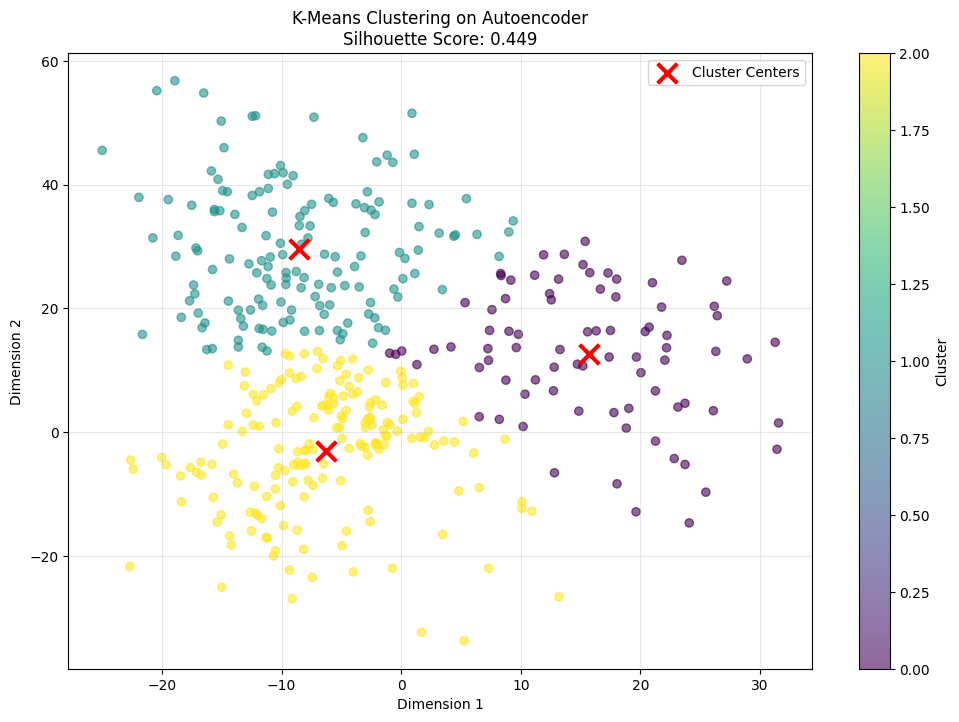

Analyzing SOM results...


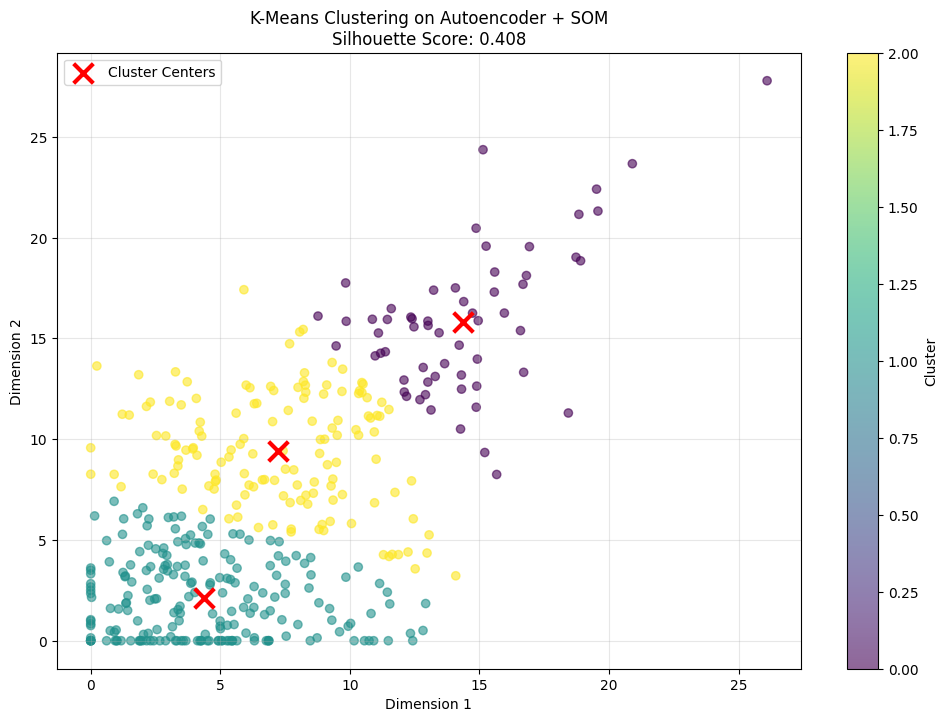

Analyzing t-SNE results...


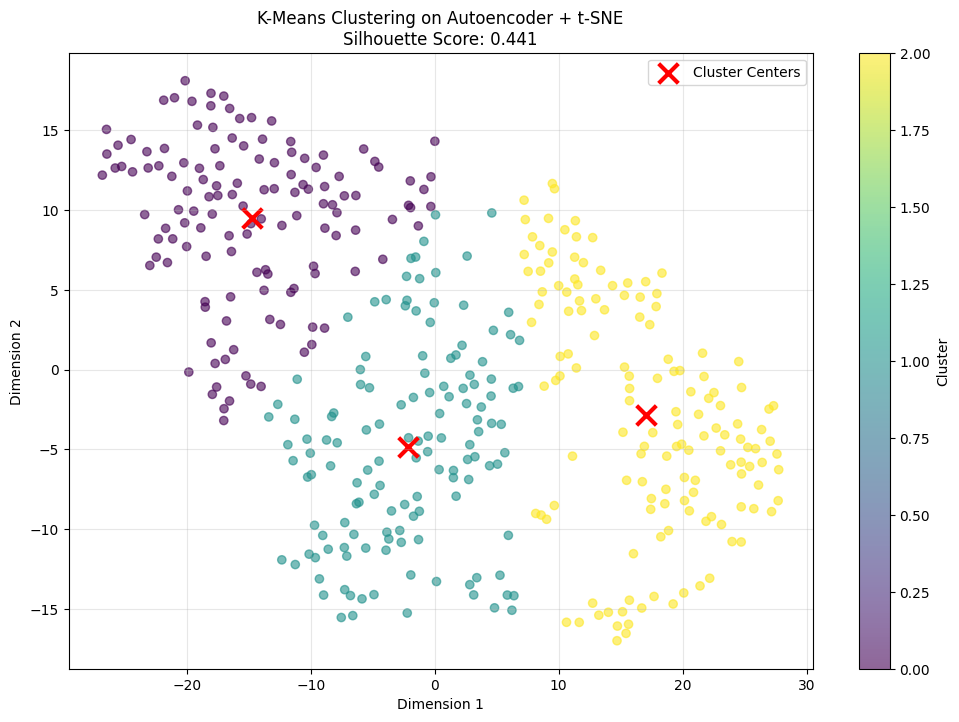

Analyzing UMAP results...


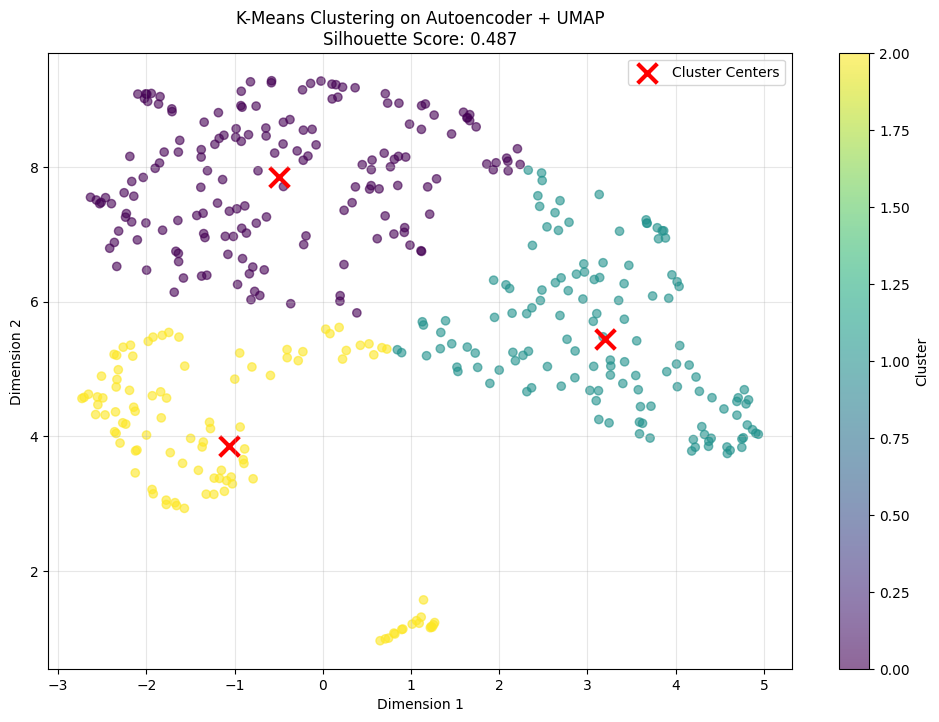

Analyzing VAE results...


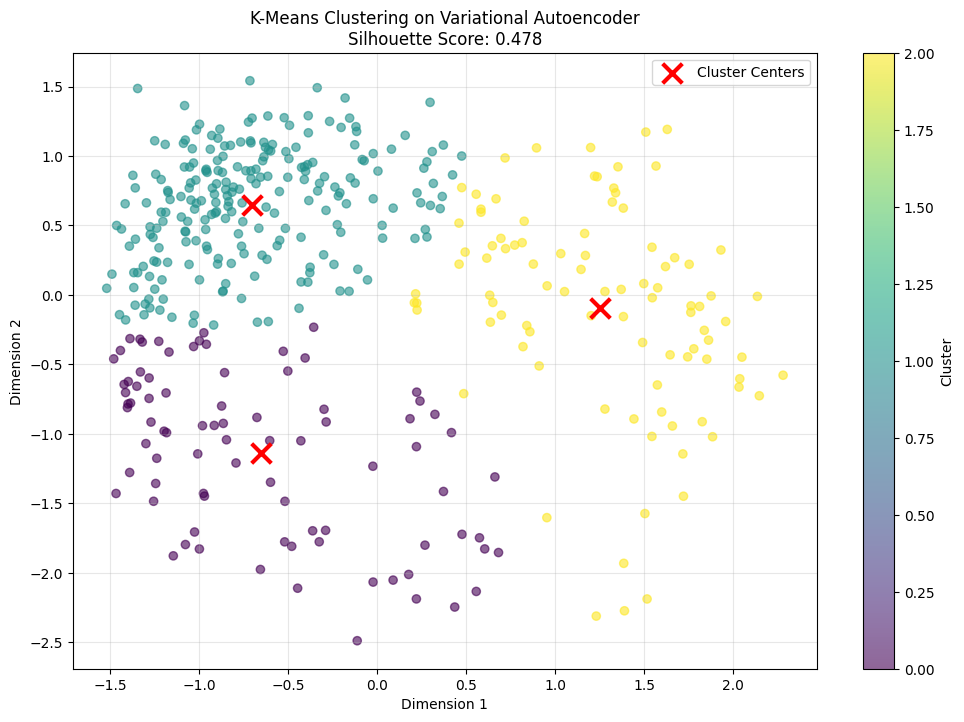

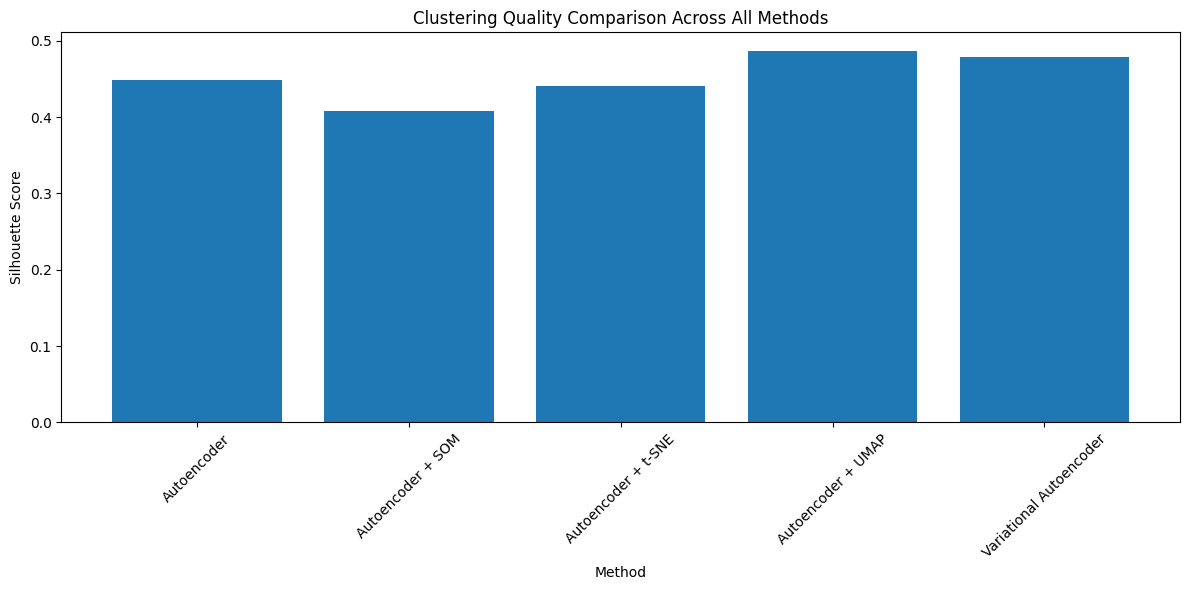


Silhouette Scores:
Autoencoder: 0.449
Autoencoder + SOM: 0.408
Autoencoder + t-SNE: 0.441
Autoencoder + UMAP: 0.487
Variational Autoencoder: 0.478


In [32]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame for VAE results
vae_df = pd.DataFrame(latent_representations, columns=['Dimension 1', 'Dimension 2'])

def apply_kmeans_and_visualize(data, method_name, n_clusters=3):
    """
    Apply k-means clustering on 2D reduced data and visualize results

    Parameters:
    data (DataFrame): 2D reduced data with columns ['Dimension 1', 'Dimension 2']
    method_name (str): Name of the dimensionality reduction method
    n_clusters (int): Number of clusters for k-means
    """
    # Apply k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(data, clusters)

    # Create visualization
    plt.figure(figsize=(12, 8))

    # Scatter plot with clusters
    scatter = plt.scatter(data['Dimension 1'], data['Dimension 2'],
                         c=clusters, cmap='viridis', alpha=0.6)

    # Plot cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x',
               s=200, linewidths=3, label='Cluster Centers')

    plt.title(f'K-Means Clustering on {method_name}\nSilhouette Score: {silhouette_avg:.3f}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return clusters, silhouette_avg

# Dictionary to store results
results = {}

# Analyze each method
print("Analyzing Autoencoder results...")
clusters_ae, score_ae = apply_kmeans_and_visualize(encoded_df, 'Autoencoder')
results['Autoencoder'] = score_ae

print("Analyzing SOM results...")
clusters_som, score_som = apply_kmeans_and_visualize(som_df, 'Autoencoder + SOM')
results['Autoencoder + SOM'] = score_som

print("Analyzing t-SNE results...")
clusters_tsne, score_tsne = apply_kmeans_and_visualize(tsne_df, 'Autoencoder + t-SNE')
results['Autoencoder + t-SNE'] = score_tsne

print("Analyzing UMAP results...")
clusters_umap, score_umap = apply_kmeans_and_visualize(umap_df, 'Autoencoder + UMAP')
results['Autoencoder + UMAP'] = score_umap

print("Analyzing VAE results...")
clusters_vae, score_vae = apply_kmeans_and_visualize(vae_df, 'Variational Autoencoder')
results['Variational Autoencoder'] = score_vae

# Visualize comparison of methods
plt.figure(figsize=(12, 6))
methods = list(results.keys())
scores = list(results.values())
plt.bar(methods, scores)
plt.title('Clustering Quality Comparison Across All Methods')
plt.xlabel('Method')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the scores
print("\nSilhouette Scores:")
for method, score in results.items():
    print(f"{method}: {score:.3f}")

Looking at the clustering results across different dimensionality reduction techniques, we can observe several interesting patterns and draw meaningful conclusions about their effectiveness in analyzing this dataset.
UMAP emerges as the most effective method, achieving the highest silhouette score of 0.487. The visualization shows remarkably clear and natural cluster separation, with each group of points forming distinct, cohesive clusters. The boundaries between clusters are well-defined, and there's minimal overlap between different groups. This suggests that UMAP successfully preserves both local and global structure of the high-dimensional data, making it particularly valuable for this analysis.
The basic autoencoder approach, with a silhouette score of 0.449, demonstrates good performance but with some notable differences from UMAP. While it successfully identifies three main clusters, these clusters appear more dispersed and show some overlap at their boundaries. This suggests that while the autoencoder captures the fundamental structure of the data, it may not be as effective at preserving the fine-grained relationships between data points that UMAP manages to maintain.
T-SNE produces results similar to the basic autoencoder, achieving a silhouette score of 0.441. Its visualization shows clear cluster separation, but with a different spatial arrangement compared to UMAP and the basic autoencoder. T-SNE's tendency to focus on local structure is evident in how it arranges the clusters, spreading them out more in the 2D space. This characteristic of t-SNE can be both advantageous and limiting, as it might emphasize local patterns at the expense of global relationships in the data.
The SOM-based approach yields the lowest silhouette score of 0.408. Its visualization reveals a more structured but somewhat artificial arrangement of points, which is characteristic of the SOM's grid-based topology. The clusters appear more constrained in their placement, and there's noticeable overlap between groups. This suggests that while SOMs can be useful for certain types of data analysis, they might be imposing too rigid a structure on this particular dataset.